# Homework 1
Section 8.1

Math 404

Winter 2020

Logan Schelly

In [1]:
import gc
import time
import numpy as np
from matplotlib import pyplot as plt

## Exercise 8.3
Code up the RLS algorithm described in Proposition 8.1.2.  Think carefully about how to avoid computing the same quantity more than once.

In [2]:
def RLS_algorithm(S, beta, x, y):
    
    f = S.dot(x)
    denom = 1 + f.dot(x)
    gamma = f / denom
    subtrahend = np.outer(f, gamma)
    new_S = S - subtrahend
    e = y - x.dot(beta)
    summand = gamma * e
    new_beta = beta + summand
    
    return new_S, new_beta

## Exercise 8.4
Draw a sample $(\mathbf{x}_1, y_1), \ldots, (\mathbf{x}_n, y_n)$ of length $n=10^5$ from a distribution $y = \mathbf{x}^T\boldsymbol{\beta}-6+\varepsilon$, where $\beta = (1, 2, 3, 4, 5)$ and $\varepsilon \sim \mathscr{N}(0, 0.5)$.
Hint: Remember also that an extra column of ones needs to be included to account for the constant shift.

In [3]:
n = 10**5
d = 6

#X ~ Unif([a, b))
alpha, b = 0, 100
X = np.random.random((n, d))*(b-alpha) + alpha
X[:,-1] = 1 #Column of ones.
beta = np.array([1, 2, 3, 4, 5, -6])

eps_var = 0.5
eps_std = np.sqrt(eps_var)
epsilon = np.random.normal(loc=0, scale=eps_std, size=n)

Y = X.dot(beta) + epsilon #-6 included from the column of negative ones.

Apply your code from the previous problem to this dataset to recursively compute $\hat{\beta}$.

In [4]:
class RLSRegressor():
    
    def __init__(self, d):
        """
        d -- the number of features of the incoming data.
        """
        self.d = d
        self.beta = None
        self.S = None
    
    def adapt(self, x, y):
        """
        Adapts an observation, (x, y), into the model.
        """
        assert x.size == self.d
        
        #Deal with the case where we haven't had enough observations
        if self._still_initializing():
            self._adapt_init(x, y)
        
        #If we DO have enough observations:
        else:
            S, beta = self.S, self.beta
            self.S, self.beta = RLS_algorithm(S, beta, x, y)
            
            
    def _still_initializing(self):
        """
        To be changed by child classes.
        """
        raise NotImplementedError
    
    def _adapt_init(x, y):
        """
        To be changed by child classes.
        """
        raise NotImplementedError

### Part 1
Experiment with initializing by collecting a few initial data points, solving the OLS problem for those points, and then updating after that.

In [5]:
class RLSCollectingRegressor(RLSRegressor):
    """
    Collects data points until X^T X is invertible.
    """
    def __init__(self, d):
        
        #Invoke the parent constructor.
        super(RLSCollectingRegressor, self).__init__(d)
        
        #Initialize storage for data points.
        self.num_storage_rows = 2*d
        self.X_temp = np.empty((self.num_storage_rows, d)) #holds the observations
        self.Y_temp = np.empty(self.num_storage_rows)
        self.observations_stored = 0
        self.done_initializing = False
    
    def _still_initializing(self):
        
        return not self.done_initializing
    
    def _adapt_init(self, x, y):
        
        #Check to make sure we have room to store this.
        if self.observations_stored >= self.num_storage_rows:
            #Allocate room.  Double the number of storage rows.
            new_X_temp = np.empty((2*self.num_storage_rows, d))
            new_X_temp[:self.num_storage_rows,:] = self.X_temp
            new_Y_temp = np.empty(2*self.num_storage_rows)
            new_Y_temp[:self.num_storage_rows] = self.Y_temp
            self.X_temp = new_X_temp
            self.Y_temp = new_Y_temp
            self.num_storage_rows *= 2
        
        #Store this observation.
        self.X_temp[self.observations_stored] = x
        self.Y_temp[self.observations_stored] = y
        self.observations_stored += 1
        
        #Solve for beta via ols.
        X = self.X_temp[:self.observations_stored]
        Y = self.Y_temp[:self.observations_stored]
        soln, residuals, rank, s_vals = np.linalg.lstsq(X, Y, rcond=None)
        self.beta = soln
        
        #See if we can store S_t and be done.
        if rank >= self.d:
            self.done_initializing = True
            self.S = np.linalg.inv(X.T.dot(X))

*Approximately how many points do you need to have a hope that the initial $S_t$ will be invertible?*

If you have less than $d$ data points, you have no hope of $S_t$ being invertible.  So, you need at least $d$ data points.
For this specific problem, $d = 6$.

In [6]:
#Let's see how the collection technique does.
collecting_regressor = RLSCollectingRegressor(d)

#We'll also need to store times for later on.
rls_collecting_times = list()
ols_times = list()
ols_sizes = [0, 9, 99, 999, 9999, 59999, 99999]

for t, (xt, yt) in enumerate(zip(X, Y)):
    Xt = X[:t+1]
    Yt = Y[:t+1]
    
    #Time how long it takes to do RLS with collecting.
    gc.disable()
    t_start = time.time()
    collecting_regressor.adapt(xt, yt)
    rls_collecting_times.append(time.time() - t_start)
    gc.enable()
    
    #Collect reference points for OLS.
    if t in ols_sizes:
        
        print("Iteration", t)
        
        #Time the amount of time it takes to do OLS.
        gc.disable()
        t_start = time.time()
        ols_beta, rs, rank, s_vals = np.linalg.lstsq(Xt, Yt, rcond=None)
        ols_times.append(time.time() - t_start)
        gc.enable()

        #Compare the two betas
        rls_beta = collecting_regressor.beta
        distance = np.linalg.norm(rls_beta - ols_beta)
        err_tol = 10**-5
        too_different = distance > err_tol
        if too_different:
            print("Not close!")
            print("OLS beta vs RLS beta:")
            side_by_side = np.vstack((ols_beta, rls_beta)).T
            print(side_by_side)

        print("Distance apart:", distance)
        print()

Iteration 0
Distance apart: 0.0

Iteration 9
Distance apart: 1.1157453067180868e-12

Iteration 99
Distance apart: 1.803495708822916e-13

Iteration 999
Distance apart: 7.66581463513448e-14

Iteration 9999
Distance apart: 1.6450649861129337e-12

Iteration 59999
Distance apart: 7.428340227486365e-13

Iteration 99999
Distance apart: 3.002422752199767e-12



### Part 2
Experiment with initializing by choosing $S_0^{-1} = a I$ for some $a > 0$.

In [7]:
#Make a class that does this.
class RLSInitializingRegressor(RLSRegressor):
    """
    Collects data points until X^T X is invertible.
    """
    def __init__(self, d, a):
        
        #Invoke the parent constructor.
        super(RLSInitializingRegressor, self).__init__(d)
        
        #Initialize S.
        self.S = np.eye(d) / a
        
        #Initialize beta to be zero.
        self.beta = np.zeros(d)
    
    def _still_initializing(self):
        
        return False

In [8]:
#Experiment with different a values.
true_variance = (b-alpha)**2 / 12 #Variance for X~Unif(alpha,b)
initialize_S_times = list()

for scale in np.array([.001, 1, 100]):
    a = true_variance * scale
    init_rls = RLSInitializingRegressor(d, a)
    print("\tscale = ", scale)
    for t, (x, y) in enumerate(zip(X, Y)):
        if np.isclose(a, true_variance):
            gc.disable()
            t_start = time.time()
            init_rls.adapt(x, y)
            initialize_S_times.append(time.time() - t_start)
            gc.enable()
        else:
            init_rls.adapt(x, y)

        if t in ols_sizes:

            ols_beta, rs, rank, s_vals = np.linalg.lstsq(Xt, Yt, rcond=None)

            #Compare the two betas
            rls_beta = init_rls.beta
            distance = np.linalg.norm(rls_beta - ols_beta)

            print("Iteration", t)
            print("Distance apart:", distance)
            print()
        
        

	scale =  0.001
Iteration 0
Distance apart: 8.39897509494479

Iteration 9
Distance apart: 4.183552535114474

Iteration 99
Distance apart: 0.8663584261319456

Iteration 999
Distance apart: 0.22321145987172147

Iteration 9999
Distance apart: 0.035851039877002

Iteration 59999
Distance apart: 0.004353164827801726

Iteration 99999
Distance apart: 0.0008122783856619516

	scale =  1.0
Iteration 0
Distance apart: 8.404430614915519

Iteration 9
Distance apart: 6.041854076101624

Iteration 99
Distance apart: 6.01222618015207

Iteration 999
Distance apart: 5.662226681028949

Iteration 9999
Distance apart: 3.433441104334749

Iteration 59999
Distance apart: 1.105322354889881

Iteration 99999
Distance apart: 0.7162654041840688

	scale =  100.0
Iteration 0
Distance apart: 9.291689994516455

Iteration 9
Distance apart: 7.024905229439931

Iteration 99
Distance apart: 6.245636916993741

Iteration 999
Distance apart: 6.0568296077044135

Iteration 9999
Distance apart: 6.007551040599972

Iteration 59999
D

---
What size, roughly, should $a$ be?

---
We're in a bit of a goldilocks situation here.
We should expect $S_t^{-1}$ to converge in distribution to a normal distribution centered at $tCov(X)$, because
$S_t^{-1} = (\mathbb{X}_t^T\mathbb{X}) = \sum_{i=1}^{t}\mathbf{x}_i\mathbf{x}_i^T$.
Our update is
$$
S_{t+1}^{-1} = S_t^{-1} + \mathbf{x}_{t+1}\mathbf{x}_{t+1}^T,
$$
and therefore
$$
S_t^{-1} = S_{0}^{-1} + \sum_{i=1}^{t}\mathbf{x}_{i}\mathbf{x}_{i}^T.
$$
If $S_0^{-1}$ is much larger than $cov(X)$, then the convergence will take awhile, because it will take awhile for
$\sum_{i=1}^{t}\mathbf{x}_{i+1}\mathbf{x}_{i+1}^T$ to grow larger than $S_0^{-1}$.
If $S_0^{-1}$ is significantly smaller than $cov(X)$, the first few values of $S_t$ will be highly dependent on the first few observed values of $X$.
To remedy this, we can make $S_0^{-1} = Cov(X)$.
In our case, the $\mathbf{x}_i$ are all drawn from $Uniform(\alpha, b)$, where $\alpha=0$ and $b=100$.
So, we'd like $a$ to equal the true variance, $(b - \alpha)^2 / 12$.

(Alternatively, we could set $a$ to be *very* small to make the beta values *very* close to the collection method, since the difference between the $S_t^{-1}$'s is $S_0^{-1}$.  We can't set $S_0 = 0_{d\times d}$, however.  That would not be invertible.)

---

What are you assuming about the data if $a$ is very small?  What if it is very large?

----
The size of $a$ roughly corresponds to the variance of the data.  If $a$ is small, there is not much variance.  If it is large, there is a lot of variance.

---

Compare the speed up of one update of RLS to the speed of computing the OLS solution for one time step.
How does the complexity of the OLS solution change as more data arrives?

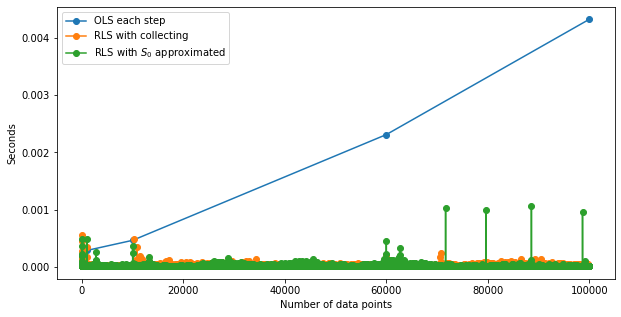

In [13]:
plt.figure(figsize=(10, 5))
rls_sizes = np.arange(n)
plt.plot(ols_sizes, ols_times, 'o-', label='OLS each step')
plt.plot(rls_sizes, rls_collecting_times, 'o-',  label='RLS with collecting')
plt.plot(rls_sizes, initialize_S_times, 'o-', label='RLS with $S_0$ approximated')
plt.xlabel("Number of data points")
plt.ylabel("Seconds")
plt.legend(loc='upper left')
plt.show()

OLS grows linearly while RLS remains constant.
Once we get past 20,000 data points, the speed up is noticeably better.